# QAOA for random bond Ising model (RBIM)

In [63]:
import qaoa
import qucompsys as qucs
import graphs as gr
import qutip as qu
import numpy as np
import matplotlib.pyplot as plt
from   matplotlib import cm
from   matplotlib.ticker import LinearLocator, FormatStrFormatter
import networkx as nx
from   networkx.generators.random_graphs import erdos_renyi_graph
import configparser
import scipy
import itertools
from collections import Counter

import importlib
importlib.reload(qaoa)
importlib.reload(qucs)

%matplotlib inline
%config InlineBackened.figure_format = 'svg'

##  0 Define the graph

In [189]:
# grid graph
n_nodes = 4
nodes = np.arange(0, n_nodes, 1)
edges = [(0, 1), (1, 2), (2, 3), (3, 0)]

In [200]:
# grid graph
n_nodes = 6
nodes = np.arange(0, n_nodes, 1)
edges = [(0, 1), (1, 2), (1,4), (2, 3), (3, 4), (4, 5), (5, 0)]

In [64]:
# grid graph
n_nodes = 9
nodes = np.arange(0, n_nodes, 1)
edges = [(0, 1), (0,3), (1, 2), (1, 4), (2, 5), (3,4), (3,6), (4, 5), (4, 7), (5,8), (6, 7), (7, 8)]

In [201]:
n_qubits = n_nodes
graph = nx.Graph()
graph.add_nodes_from(nodes)
graph.add_edges_from(edges)
edges = list(graph.edges)

### 0.1 plot the graph

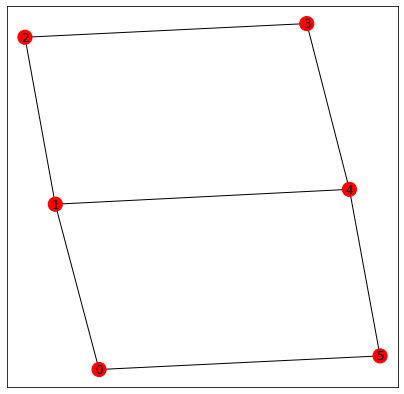

In [202]:
fig = plt.figure(figsize = (7,7))
colors = ['r' for node in graph.nodes()]
pos = nx.planar_layout(graph)
graph_drawing = nx.draw_networkx(graph, node_color=colors, node_size=200, pos = None, alpha=1, with_labels=True)
plt.show()

## 1 choose probability

$$H_{RBIM} = -\sum_{<i,j>}K_{ij}Z_iZ_j,$$

$P(K_{ij}) = p\delta(K_{ij}-K) + (1-p)\delta(K_{ij}+K) \; , K>0$

In [68]:
prob = 0.7 #prbability 0.5 < prob < 1 that the site is ferromagnetic (all 1 or -1), expect phase-transistion at p = 0.88

bin_prob_dist = np.random.binomial(1, prob, size=(len(edges),)) # 1 for ferromagnetic link

bin_prob_dist

array([1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0])

In [69]:
for i, link in enumerate (bin_prob_dist):
    if link == 0:
        bin_prob_dist[i] = -1
bin_prob_dist

array([ 1,  1, -1,  1, -1,  1,  1,  1, -1,  1, -1, -1])

In [70]:
def binomial_dist(prob, edges):
    bin_prob_dist = np.random.binomial(1, prob, size=(len(edges),)) # 1 for ferromagnetic link
    for i, link in enumerate (bin_prob_dist):
        if link == 0:
            bin_prob_dist[i] = -1
    return bin_prob_dist

In [205]:
bin_prob_dist = binomial_dist(0.5, edges)
bin_prob_dist

array([-1,  1,  1,  1, -1, -1, -1])

## 2 Define needed functions

In [207]:
I = qu.tensor([qu.qeye(2)]*n_qubits)
X = []
for i in range(n_qubits):
    X.append(qu.tensor([qu.qeye(2)]*i+[qu.sigmax()]+[qu.qeye(2)]*(n_qubits-i-1)))
Y = []
for i in range(n_qubits):
    Y.append(qu.tensor([qu.qeye(2)]*i+[qu.sigmay()]+[qu.qeye(2)]*(n_qubits-i-1)))
Z = []
for i in range(n_qubits):
    Z.append(qu.tensor([qu.qeye(2)]*i+[qu.sigmaz()]+[qu.qeye(2)]*(n_qubits-i-1)))
P_0 = []
for i in range(n_qubits):
    P_0.append(qu.tensor([qu.qeye(2)]*i+[qu.ket('0').proj()]+[qu.qeye(2)]*(n_qubits-i-1)))
P_1 = []
for i in range(n_qubits):
    P_1.append(qu.tensor([qu.qeye(2)]*i+[qu.ket('1').proj()]+[qu.qeye(2)]*(n_qubits-i-1)))
H_B = sum(X)

In [15]:
def evaluate_energy_ising(list_z, edges, bin_prob_dist, coupling_const=1):
    energy = 0
    for i, edge in enumerate(edges):
        energy += -bin_prob_dist[i]*list_z[edge[0]]*list_z[edge[1]]
    return coupling_const*energy

In [17]:
def evaluate_magnetization_ising(list_z):
    return abs(sum(list_z))

In [46]:
def single_qubit_measurement_ising(qstate, qubit_pos):
    n_qubits = len(qstate.dims[0])
    M_i = P_0[qubit_pos]*qstate
    if qstate.dims[1][0] == 1:
        p0_i = float(abs((qstate.dag()*M_i).full()))
        if np.random.random_sample() <= p0_i:
            outcome = [1]
            qstate = M_i/np.sqrt(p0_i)
        else:
            outcome = [-1]
            qstate = (P_1[qubit_pos]*qstate)/np.sqrt((1-p0_i))
    else:
        p0_i = M_i.tr()
        if np.random.random_sample() <= p0_i:
            outcome = [1]
            qstate = M_i/p0_i
        else:
            outcome = [-1]
            qstate = (P_1[qubit_pos]*qstate)/(1-p0_i)
    return outcome, qstate

def quantum_measurements_ising(n_samples, qstate):
    n_qubits = len(qstate.dims[0])
    outcomes = []
    for j in range(n_samples):
        outcome = []
        qstate_dummy = qstate.copy()
        for i in range(n_qubits):
            outcome_i, qstate_dummy = single_qubit_measurement_ising(qstate_dummy, i)
            outcome += outcome_i
        outcomes.append(outcome)
    return outcomes

In [48]:
def prob_hamilt_ising(n_qubits, edges, bin_prob_dist, coupling_const=1):
    list_double_sigmaz = []
    for i, edge in enumerate(edges):
        list_double_sigmaz.append(Z[edge[0]]*Z[edge[1]]*bin_prob_dist[i]) 
    return -sum(list_double_sigmaz)*coupling_const

In [49]:
def evolution_operator_ising(n_qubits, edges, gammas, betas, bin_prob_dist):
    evol_oper = I
    for i in range(len(gammas)):
        u_mix_hamilt_i = (-complex(0,betas[i])*H_B).expm()
        u_prob_hamilt_i = (-complex(0,gammas[i])*prob_hamilt_ising(n_qubits, edges, bin_prob_dist)).expm()
        evol_oper = u_mix_hamilt_i*u_prob_hamilt_i*evol_oper
    return evol_oper

In [50]:
def evaluate_energy_p(params, n_qubits, edges, bin_prob_dist, n_samples):
    gammas = params[:int(len(list(params))/2)]
    betas = params[int(len(list(params))/2):]
    
    # initial state (as density matrix):
    #dm_init_state = qu.ket2dm(initial_state(n_qubits))
    init_state = qaoa.initial_state(n_qubits)
    #obtain final state
    #dm_fin_state = evolution_operator(n_qubits, edges, gammas, betas)*dm_init_state*evolution_operator(n_qubits, edges, gammas, betas).dag()
    fin_state = evolution_operator_ising(n_qubits, edges, gammas, betas, bin_prob_dist)*init_state
    #fin_state = qaoa.evolution_operator(n_qubits, edges, gammas, betas)*init_state

    
    #Perform N measurements on each single qubit of final state
    outcomes = quantum_measurements_ising(n_samples, fin_state)
    dict_outcomes = {}
    for outcome in outcomes:
        dict_outcomes[tuple(outcome)] = outcomes.count(outcome)
    
    #Evaluate Fp
    Ep = 0
    for outcome_w in dict_outcomes:
        Ep += dict_outcomes[outcome_w]*evaluate_energy_ising(outcome_w, edges, bin_prob_dist)
    return Ep/n_samples

## 1 Parameters optimization

## 1.1 Choose QAOA level and pick initial parameters

## 1.2 Generate initial state

${\large |s\rangle = \sum_{z \, \in \, \{0,1\}^n}^{}{|z\rangle} = |+\rangle^{\otimes n}}$

## 1.3 Obtain final state

${\large |\vec{\gamma},\vec{\beta}\rangle = U(B,\beta_p)U(C,\gamma_p)...U(B,\beta_1)U(C,\gamma_1)|s\rangle}$

##  1.4 Perform N-computational_basis measurements on $|\vec{\gamma},\vec{\beta}\rangle$ and evaluate $F_p$

### 1.5 Parameters update

In [208]:
#Adam
#perform it for exp_F_1 (check if this method works properly for p=1 case)
n_levels = 1
n_steps = 30
#parameters = np.array(np.pi/2*np.random.random_sample(2*n_levels)) #check how choose initial params, for pi*rand is too dispersive
parameters = np.array(np.random.uniform(-np.pi/4, np.pi/4, 2*n_levels)) #check how choose initial params, for pi*rand is too dispersive
#parameters = 0.01*np.random.rand(2*n_levels)
init_state = qaoa.initial_state(n_qubits)
beta_1 = 0.9
beta_2 = 0.999
epsilon = 1e-8
m_t = np.zeros(2*n_levels)
v_t = np.zeros(2*n_levels)
t = 0
adam_grad_fin_diff_g = []
adam_grad_fin_diff_b = []
adam_grad_fin_diff_E = []
H_P = prob_hamilt_ising(n_qubits, edges, bin_prob_dist)
eta = 0.05 #works also for eta = 0.01, but increases very slowly, and 0.1 oscillates too much around max
previous_g_t = np.zeros(2*n_levels)
for i in range(n_steps):
    g_t = qaoa.fin_diff_grad(evaluate_energy_p, parameters, args=(n_qubits, edges, bin_prob_dist, 100), increment=0.1)
    gammas = parameters[:n_levels]
    betas = parameters[n_levels:]
    fin_state = evolution_operator_ising(n_qubits, edges, gammas, betas, bin_prob_dist)*init_state
    E_p_adam = qu.expect(H_P, fin_state)
    adam_grad_fin_diff_g.append(gammas[0])
    adam_grad_fin_diff_b.append(betas[0])
    adam_grad_fin_diff_E.append(E_p_adam)
    #if (np.sign(g_t) == -np.sign(previous_g_t)).all() and (np.sign(g_t) == -np.sign(np.ones(2*n_levels))).all():
        #break
    #if (i + 1) % 1 == 0:
    print('in', parameters, 'with grad ', g_t,  "objective after step {:5d}: {: .7f}".format(i + 1, E_p_adam))
    t = t+1
    m_t = beta_1*m_t + (1-beta_1)*g_t
    v_t = beta_2*v_t + (1-beta_2)*g_t**2
    m_t_hat = m_t/(1-beta_1**t)
    v_t_hat = v_t/(1-beta_2**t)
    parameters = parameters - eta*m_t_hat/(np.sqrt(v_t_hat) + epsilon)
    #previous_g_t = g_t
optimal_parameters_Adam_fin_diff = parameters
optimal_gammas = optimal_parameters_Adam_fin_diff[:n_levels]
optimal_betas = optimal_parameters_Adam_fin_diff[n_levels:]
print('optimal parameters are ', optimal_parameters_Adam_fin_diff, 'and F_1 is', qu.expect(H_P, evolution_operator_ising(n_qubits, edges, gammas, betas, bin_prob_dist)*init_state))

in [-0.01209259  0.1942739 ] with grad  [11.5 -1. ] objective after step     1: -0.1186513
in [-0.06209259  0.2442739 ] with grad  [13.4 -2.6] objective after step     2: -0.7107998
in [-0.11214598  0.29102458] with grad  [ 9.1 -2.6] objective after step     3: -1.3791362
in [-0.16117382  0.33923709] with grad  [12.3 -6. ] objective after step     4: -2.0100599
in [-0.210617    0.38493097] with grad  [ 8.2 -0.9] objective after step     5: -2.5129398
in [-0.25908656  0.42667499] with grad  [4.5 0.7] objective after step     6: -2.8162593
in [-0.30486087  0.4599404 ] with grad  [0.1 1.2] objective after step     7: -2.9233757
in [-0.34493626  0.48442437] with grad  [-2.3  2.5] objective after step     8: -2.8932545
in [-0.37785611  0.49679033] with grad  [-2.7  8.2] objective after step     9: -2.8225559
in [-0.40430998  0.48648307] with grad  [-1.9  3.7] objective after step    10: -2.8215878
in [-0.42604133  0.47017181] with grad  [-6.9  4.4] objective after step    11: -2.8200478
in 

In [209]:
H_P = prob_hamilt_ising(n_qubits, edges, bin_prob_dist)
fin_state = evolution_operator_ising(n_qubits, edges, gammas, betas, bin_prob_dist)*init_state
E_p_adam = qu.expect(H_P, fin_state)

step_size = 0.1
a_gamma_iter         = np.arange(-np.pi/4, np.pi/4, step_size)
a_beta_iter          = np.arange(-np.pi/4, np.pi/4, step_size)
grid_gammas_betas_iter = list(itertools.product(a_gamma_iter, a_beta_iter))
grid_F_1_iter = []
for par_iter in grid_gammas_betas_iter:
    fin_state = evolution_operator_ising(n_qubits, edges, [par_iter[0]], [par_iter[1]], bin_prob_dist)*init_state
    E_p = qu.expect(H_P, fin_state)
    grid_F_1_iter.append(E_p)

In [210]:
optimal_gamma_iter  = grid_gammas_betas_iter[grid_F_1_iter.index(min(grid_F_1_iter))][0]
optimal_beta_iter  = grid_gammas_betas_iter[grid_F_1_iter.index(min(grid_F_1_iter))][1]

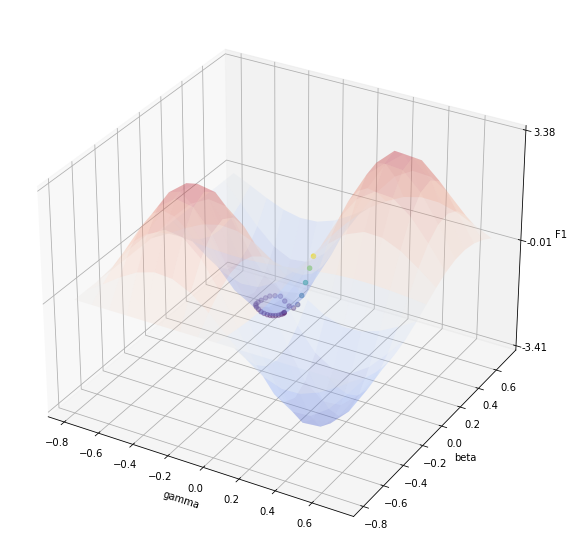


 --- OPTIMAL PARAMETERS --- 

The maximal expectation value is:  F_1 = -3.063
This is attained for gamma = -0.385 and beta = 0.415


In [211]:
#%matplotlib qt
%matplotlib inline
# Plot the expetation value grid_f_1
fig = plt.figure(figsize = (10,10))
ax  = fig.gca(projection='3d')


y_axis, x_axis = np.meshgrid(a_beta_iter, a_gamma_iter)
z_axis = np.reshape(np.array(grid_F_1_iter), y_axis.shape)

surf = ax.plot_surface(x_axis, y_axis, z_axis, cmap=cm.coolwarm, linewidth=0, antialiased=True, alpha=0.2)

#a_maximum_cut = find_maximum_cuts(n_qubits, edges)[0]
#max_cost_fun = qaoa.evaluate_cost_fun (a_maximum_cut, edges)
#max_cost_fun
#ax.set_zlim(1,max_cost_fun)
ax.zaxis.set_major_locator(LinearLocator(3))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax.set_ylabel('beta')
ax.set_xlabel('gamma')
ax.set_zlabel('F1')
ax.scatter(np.array(adam_grad_fin_diff_g), np.array(adam_grad_fin_diff_b), np.array(adam_grad_fin_diff_E), c=np.array(adam_grad_fin_diff_E), cmap='viridis', zorder=1);
#plt.scatter(np.array(adam_grad_fin_diff_g), np.array(adam_grad_fin_diff_b))
plt.show()

#The smallest parameters and the expectation can be extracted
print('\n --- OPTIMAL PARAMETERS --- \n')
print('The maximal expectation value is:  F_1 = %.03f' % np.amin(z_axis))
#print('where the max_C is ', max_cost_fun)
print('This is attained for gamma = %.03f and beta = %.03f' % (optimal_gamma_iter, optimal_beta_iter))

In [20]:
n_samples = 100
outcomes = quantum_measurements_ising(n_samples, fin_state)
dict_outcomes = {}
for outcome in outcomes:
    dict_outcomes[tuple(outcome)] = outcomes.count(outcome)

In [27]:
max_occurrency = max(list(dict_outcomes.values()))

index_max_occurrency = list(dict_outcomes.values()).index(max_occurrency)

most_probable_state = list(dict_outcomes.keys())[index_max_occurrency]

In [33]:
M = evaluate_magnetization_ising(most_probable_state)
M

4

In [ ]:
# plot probabilities of each state of the graph corresponding to every possible configuration after a cut
plt.figure(figsize = (2**n_qubits,6))
plt.xticks(rotation=45)
x_axis = []
for key in dict_outcomes:
    x_axis.append(str(key))
plt.bar(x_axis, dict_outcomes.values(), width = 0.5)

In [135]:
evaluate_energy_p(optimal_parameters_Adam_fin_diff, n_qubits, edges, bin_prob_dist, 100)

-6.8

In [130]:
prob_dist_fin_state = qucs.comp_basis_prob_dist(fin_state)

In [ ]:
# plot probabilities of each state of the graph corresponding to every possible configuration after a cut (using the state)
plt.figure(figsize = (2**n_qubits,20))
plt.xticks(rotation=90)
xticks = range(0,2**(n_qubits-1))
plt.bar(xtick_labels,prob_dist_fin_state,width = 0.5)
plt.savefig(f"./images/prob_dist_plots/n_qubits_{n_qubits}_prob_{prob}_bin_dist_{bin_prob_dist}.pdf", bbox_inches='tight')